In [3]:
import cv2 as cv
import os
import numpy as np
import subprocess as sp

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from IPython.display import display, HTML

%matplotlib inline

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Term Project Data Cleaning and Visualization

## Problem Statement and Goal

**TLDR: Creating a new method to show continuity of objects as they change shape and move in frame that is relatively computationally inexpensive.**

We are teaching a computer object continuity. We will be analyzing videos ranging from simple with single objects in the foreground, like a dog walking on grass, to complex with several objects in motion, like a city street. We are less concerned about doing a classification of the objects in the frame. This is already fairly well understood on still images; instead we hope to develop a method to detect objects that undergo significant changes in boundary shape during the course of the video. In theory this should allow us to identify objects retroactively, if they are labelled in any single frame, and then by using object persistence we can extrapolate backwards. The BHAG (big hairy audacious goal) of this project is to do this at a 24-90fps to allow for live detection in streaming video. On standard definition this is roughly 8-28 million pixels per minute and at HD video this is 50-190 million pixels per minute. Significant milestones that we acheived were creating the data pipeline, writing a new method for object segmentation, and developing and implementing a rich data structure.

## Underlying assumtions and questions to answer

**TLDR: We assume the objects in the video aren't moving fast enough to cross the whole frame in few frames.**

Part of the difficulty in tuning an algorithm to detect objects is videos differ wildly. For this project, I have selected several video clips that are of the same high quality(1080p), but are distinct. The clips were chosen to test robustness of a new segmentation method. They cover a variety of focal lengths, color schemes, camera work, etc... I will discuss the challenges of these attributes in-depth in order to better analyze the videos. 

Our assumptions about the clips are threefold: first, that the motions of objects in the video are interpolated with a high degree of accuracy by the frames; second, that objects do no dissappear or reappear except at the edges of the frame; lastly, that object interactions are simple and limited to occlusion. The first assumption is necessary for us to trust any results from this type of algorithm. The second assumption drastically limits the amount of redefining new objects, if objects are allowed to appear from the background then we can't ignore noisy background data because it might contain new objects. The last assumption is the least binding, and our end goal is to make it unecessary.


## Clip Attributes

**Camera**:
There are three main categories of camera motion that we will have to account for: fixed relative to background, fixed relative to foreground, and dynamic camera motions, like tilt and pan. Most clips will be fixed in some regard, but it is important to prepare for dynamic motions as these are common in robotics applications.

**Scene**:
This encompasses a large set of characteristics that boil down to how cluttered our images are. The simplest scene consists of a single object on a plain background. Complex scenes have many moving objects, like a crowded city street or a flock of birds. It is difficult to pinpoint what constitutes many, but it seems that more than five objects becomes unmanagable for some current algorithms.
    
**Background**:
The background of the image largely depends on how the camera is moving, however there are minute but important differences in the classes of background. Loosely there are three classes of background: constant, fluctuating, and chaotic. 
    
-Constant backgrounds have a completely static background. They most often appear with a fixed camera, they are good candidates for the BackgroundSubtraction algorithmns, but those may not produce useful results if the scene is sufficiently complex. Generally speaking, it is the easiest class of background to work with.
    
-Fluctuating backgrounds are regions that change during the video but are somewhat predictable in their behavior. A classic example would be the motioned blurred backgrounds when the camera is in a moving vehicle or ocean waves in a beach scene. These types of backgrounds can pose challenges to edge detection algorithmns because they create lots of noise from frame to frame.
    
-Chaotic backgrounds occur when the whole scene is in flux. They arise when the camera is panning or if the scene is so complex that there is no discernable background. If the motion of the tilt is known then applying variational calculus methods like deblurring may be useful.


## Data Acquisition

**TLDR: Created a data pipeline that extracts frames from video clips and runs various common image processing algorithms on them**
 
The pipeline starts off with a common video file (.mp4, .mov, .avi etc...) and extracts each of the frames to create an array of images. We then compute the changes between frames, find edges on those differences and then use the Watershed Algorithm to do basic segmentation. The Watershed Algorithim appears to have difficulties on all but the simplest of video clips. 

We have chosen video clips that represent many of the common combinations of backgrounds, camera movements and scene complexities. They are by no means exhaustive, but they should serves as a good test set for the object permenance algorithm. One of the benefits of using generic scenes is that it will test the robustness of the algorithm thoroughly.

In [6]:
#creates necessary path variables to construct the data and store it for later use

origin = os.getcwd()
raw_subfolder = 'raw'
diff_subfolder = 'diff'
segmented_subfolder = 'segmented'
canny_subfolder = 'canny'
cannydiff_subfolder = 'cannydiff'
subfolders = [raw_subfolder, diff_subfolder,canny_subfolder,segmented_subfolder,cannydiff_subfolder]
#subfolders = [raw_subfolder, diff_subfolder,canny_subfolder]


In [ ]:
os.chdir(origin)


**Extracting Images From Video Frames**

In [ ]:
cwd = os.getcwd()
cwd += "\Videos"
os.chdir(cwd)

cwd = os.getcwd()

for root, directiories, filenames in os.walk(cwd):
    #run the operation on each video
    for f in filenames:
        
        dir_name = f[:-4]
        #check if there's a folder for the video clip and if not make one
        if not os.path.exists(cwd+"\\"+dir_name):
            os.mkdir(dir_name)
    
            #create a directory for the raw images and return to the main directory
            os.chdir(cwd+"\\"+dir_name)
            
            os.mkdir(raw_subfolder)
            
            os.chdir(cwd)
        
            #Create a series of images from the frames of the video clip
            cmd='ffmpeg -i {} {}_%04d.jpg'.format(f,dir_name,)
            sp.call(cmd,shell=True)

            #Move the frames to their designated folder
            move_file = 'move {}\\*.jpg {}'.format(cwd,cwd+"\\"+dir_name+"\\"+raw_subfolder)
            sp.call(move_file,shell=True)

            #return to the video folder for the next video file
        os.chdir(origin)
        os.chdir(cwd)

os.chdir(origin)

## Data Cleaning and Preparation

Cleaning data poses an interesting set of challenges for image processing. We could do things like anisotropic diffusion to accentuate regions of color or convolve the image with a variety of smoothing/sharpening kernels, but ultimately those are expensive operations to run on large images and the results aren't always necessary for good images. Instead I've opted to run a small cheap set of operations that should elucidate motion in the video clip. The working hypothesis for the object permaneance algorithm is to create a minimally sufficient set of voronoi points that describe the objects in the scene. 

Our first set of operations aims to reduce the images to a very sparse set of meaningful pixels which we will then run noise reduction on.

### Image Difference
Finding the difference between two images helps establish the background, find objects in the foreground and is essential to discerning what is happening in a video clip. I have tried to optimize the process by paring down the amount of data being used by moving from colored to greyscale which reduced the amount of information by a factor of 3. This does pose a problem for certain kinds of scenes where the contrast between grayscale is small, but there are distinct colors. See Visualizations **bugs** for an example.

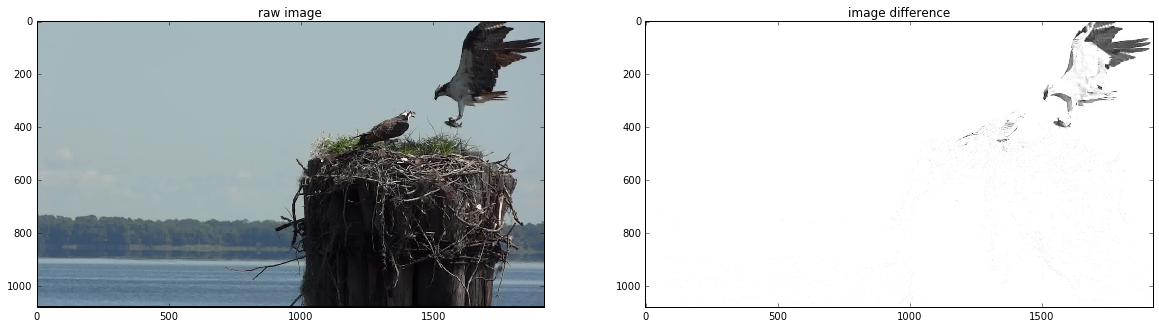

In [94]:
imcompare('osprey_raw.jpg','osprey_diff.jpg', 'raw image', 'image difference')

Image differences make it very apparent which parts of the frame change. The darker the region the more it changed between frames.

**Diffs to show motion**

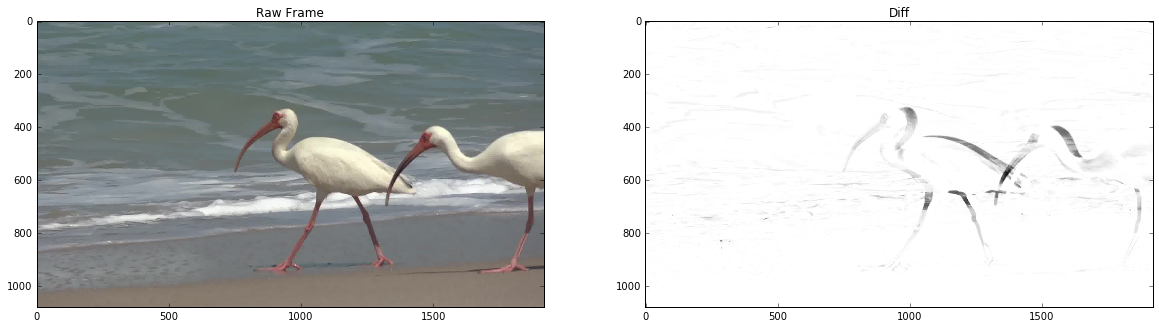

In [66]:
imcompare('ocean_birds_raw.jpg','ocean_birds_diff.jpg', 'Raw Frame', 'Diff', 'jet', 'Greys')

### Edge Detection
Edge detection helps further narrow down regions of interest and could be a good starting point for creating the set of boundary points for each object in scene. It is efficient and the results are very useful. I ran this on both the original image and the sparse diff image to generate two different ways of viewing motion transforms. I chose the Canny edge detection algorithm for its speed. see Visualizations

**Different kinds of canny edge detection**

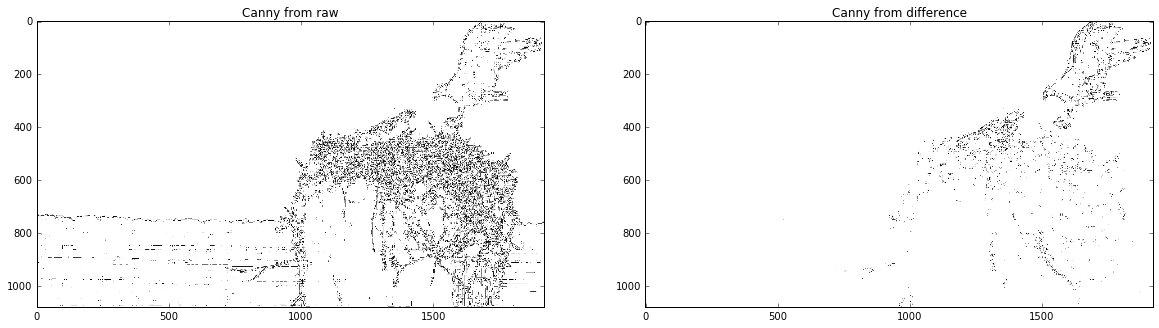

In [95]:
imcompare('osprey_canny.jpg','osprey_cannydiff.jpg', 'Canny from raw' , 'Canny from difference')

While hard to tell from this small image, running the Canny edge detection algorithm on the raw image and the difference of images provides distinct information. The Canny from raw helps provide an approximation of object boundaries. The Canny from difference provides us with what can be thought of as a transformation of the boundaries between frames. If you look cloesly you'll see a leading and trailing "edge" to the "countours" from the previous frame. With a little more feature engineering it seems possible to extract closed loop contours that provide a surjective motion mapping function. There's a lot to be developed there, but initial results are promising.

### Image Segmentation
Image segmentation and finding regions of interest is another key step in establishing which objects are in the scene and how they're moving. We chose the watershed algorithm initially after seeing impressive results from it, but have found it to be too time consuming and haven't been thrilled by how it performs on complex images.

**Image segmentation failure**

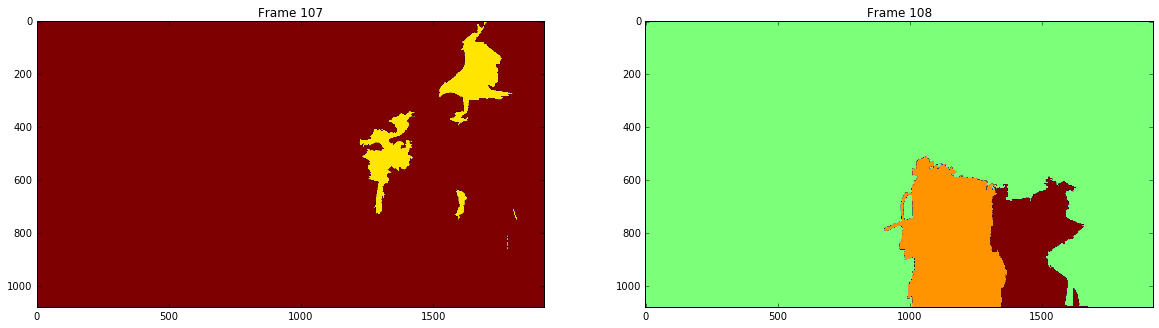

In [96]:
imcompare('osprey_seggood.jpg','osprey_segmented.jpg', 'Frame 107', 'Frame 108', 'jet', 'jet')

These images were generated by running the watershed algorithm on two consecutive frames. The first image gives fairly good segmentation for the interesting portions of the image. The second image gives almost no useful information and what's worse is it bears little resemblence the to previous frame, which breaks our assumption about interpolation.

The watershed algorithm can produce excellent results if the conditions of the image are just right. However, the images from the clips I used seemed to be too complex for it to handle well. Potentially, we could change the thresholding levels to calculate it more accurately, but it ends up being a very expensive operation then. As it stands, this is the most time consuming step. It takes several seconds to run per frame, which makes it unusable if we are to acheive our BHAG.

### Running the Operations

The code below finds which operations haven't been calculated on a data set and creates a corresponding folder for the processed images to go into. The different operations are non-destructive so that the images are preserved for later calculation and comparison. This does increase the spatial complexity significantly, approximately by a factor of 30. That increase can be mitigated if we don't store the images, like analyzing a video stream.

In [ ]:
image_pipeline('all')

In [2]:

def imcompare(path_left_image, path_right_image, title_left, title_right ,color_left = "Greys", color_right = "Greys" ):
    image_left = plt.imread(origin+"\\"+path_left_image)
    image_right = plt.imread(origin+"\\"+path_right_image)

    fig = plt.figure(figsize= (20,16))
    plt.subplot(121)
    plt.title(title_left)
    plt.imshow(image_left, cmap = color_left)

    plt.subplot(122)
    plt.imshow(image_right, cmap = color_right)

    plt.title(title_right)
    plt.show()

**Several Different Video Files**

These are snapshots from some of the clips we used to generate the data. We provide basic analysis below.

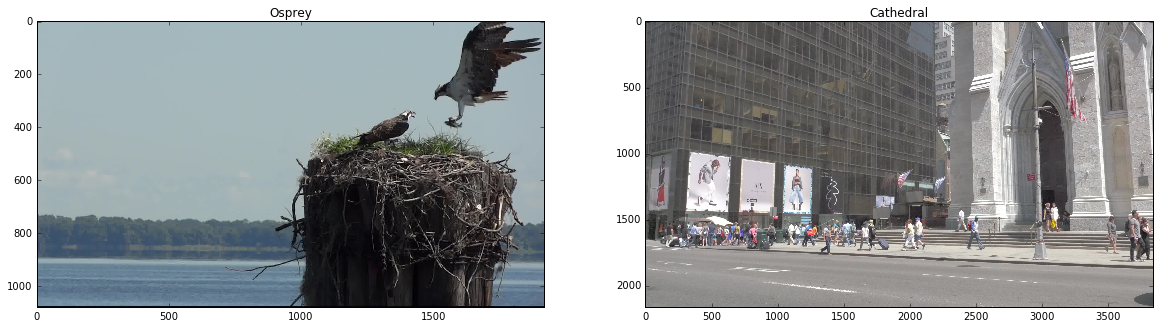

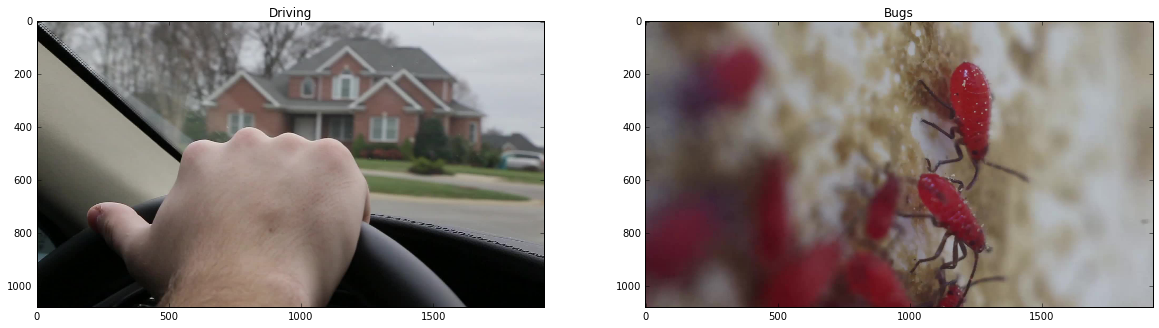

In [60]:
imcompare('images\osprey_raw.jpg'       ,'images\cathedral_raw.jpg', 'Osprey', 'Cathedral', 'jet', 'jet')
imcompare('images\SteeringWheel_raw.jpg','images\\redbugs_raw.jpg', 'Driving', 'Bugs', 'jet', 'jet')

**Osprey**

Simple scene, the only real motion is the bird landing in the nest. The camera is fixed in relation to the background and the background is almost entirely static.

**Cathedral**

A complex scene with lots of people and buildings moving. The camera pans upward causing everything to shift in frame making the background chaotic.

**Driving**

A scene where the camera is fixed in relation to the foreground. The car drives slowly so there isn't too much motion blur on the background. The background is a mix of chaotic and fluctuating depending on if the car is turning or not.

**Bugs**

A fixed camera scene with a static background, but with lots of moving objects in the foreground.

# Spatial Tree Image Compression

In [14]:
import QuadtreeChannels as qt
import time

### Quadtree Image Compression


As the bulk of this project was writing the Quadtree method we will delve deeply into the theory and rationale behind quadtree compression and how it relates to image processing. We implemented a custom version of a quadtree that contains both point and region information. Quadtrees recursively split up the space into rectangular regions based on some splitting criterion. They are a form of partitioning fractal. Quadtrees, are a subset of these fractal trees with the partion dividing the space into four equal rectangular portions. We have enriched the Quadtree data structure by representing it as 3D network tree with z-depth being the generation, but can we also project it down into the xy plane as a matrix and a hashable Set of points. Having this rich representation allows us to run various operations on whichever representation is most fitting, like neighbor/sibling searches on the tree and triangulation on the Set of points. 

The major benefit that a quadtree offers, is it preserves structural information about the image while simultaneously compressing the image down to a collection of nodes. Several important operations on nodes can be equated to the regions they represent, but are significantly computationally cheaper to run. 

The current build of the tree is expansible and tunable. We have included several control options on the alrogithm including: splitting criterion, max depth, fractal partion, and splitting threshhold.


### Splitting Criterion

Let's compare some of the different parameter choices. We will compare the two splitting criterion side by side at different thresholds. A larger threshold results in a sparser tree. The two splitting criterion are: Manhattan Distance over region and Variance over region. There are other potential metrics, but these two are relatively cheap and robust.

**Manhattan Distace**

The Manhattan distance between two coplanar points is defined as 

$$Total\ Manhattan\ Distance = \sum_{i=0}^{N} \sum_{j=0}^{M} |\  x_{ij} \  - \tilde{x} \  | + |\  y_{ij} - \tilde{y}\ |$$.

The Manhattan distance is cheaper to calculate, but tends exacerbate the self-similar edge problem. We also normalized the distance by the area it covered to help tune our thresholds.

**Variance**

 The variance of a region is considerably more expensive to compute than the Manhattan distance for large regions, but it produces better results in terms of loss/compression. On smaller regions, comparing the variance of a region runs at a comparable speed to the Manhattan distance. We can by pass the larger regions by assuming they will split, which ends up being a very safe assumption for any real world image. The number of splits can be tuned to the size of the image.

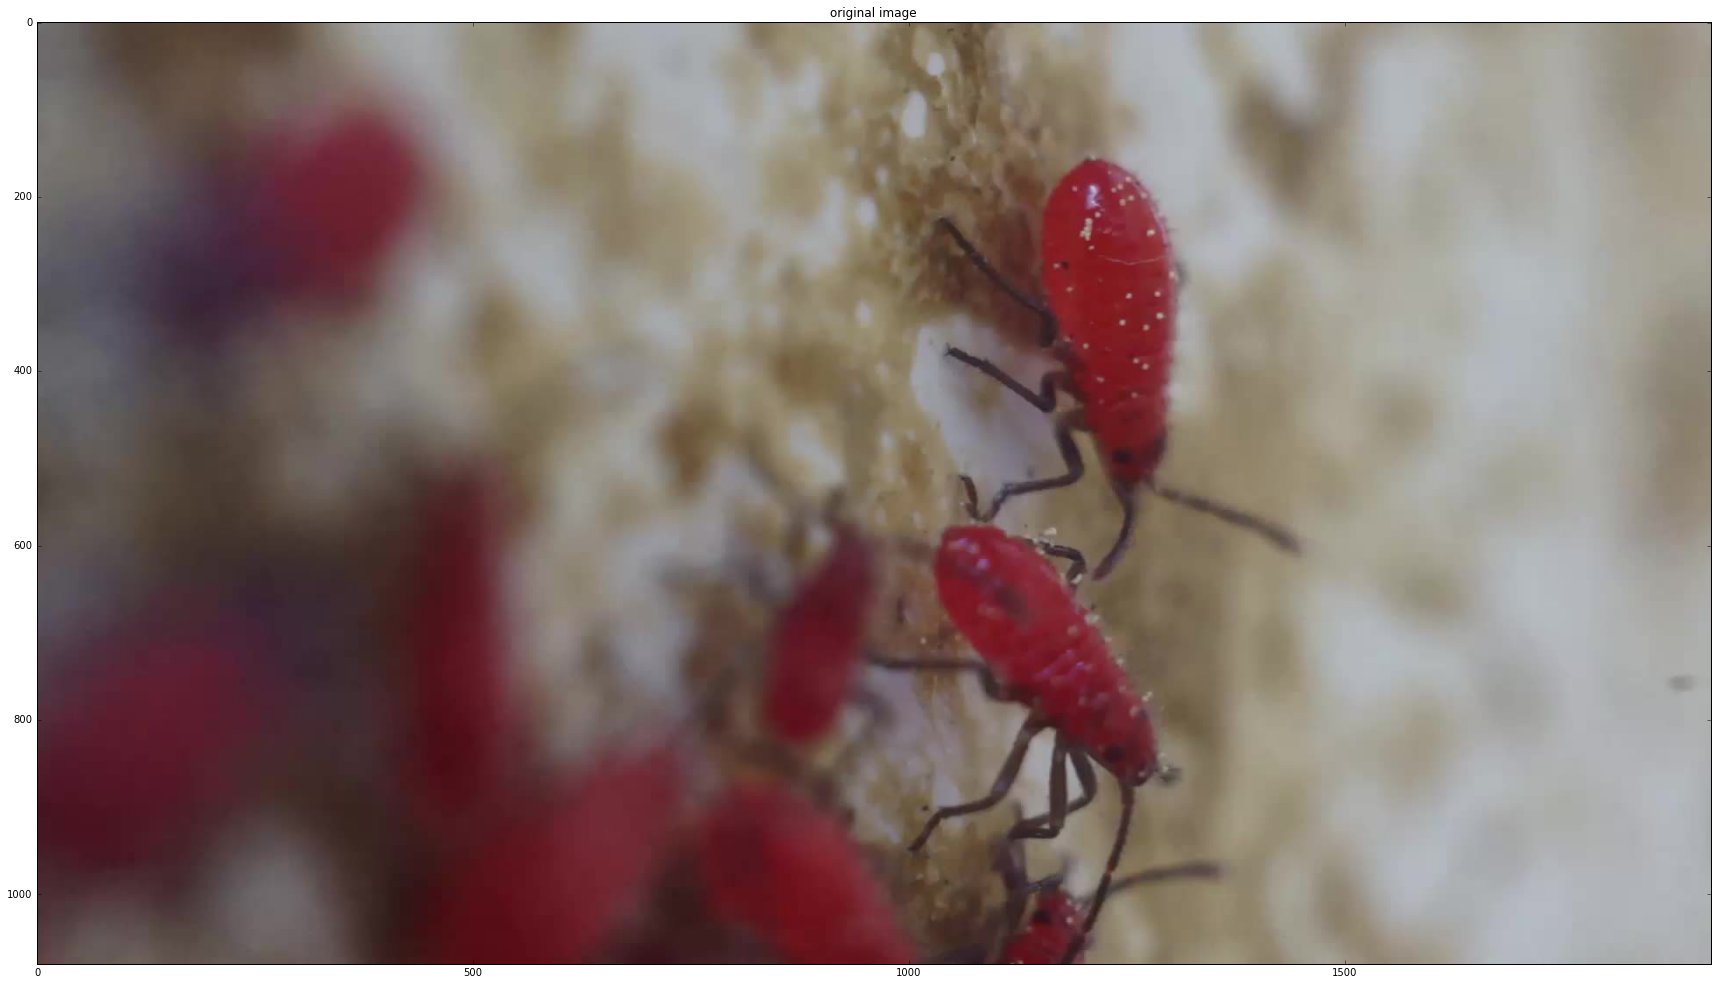

The manahattan splitting criterion took 1.68099999428 seconds to build.
It reduced to image from 2073600 pixels down to 4447nodes
Reducing the size by a factor of 466

The variance splitting criterion took 2.43799996376 seconds to build.
It reduced to image from 2073600 pixels down to 3556 nodes
Reducing the size by a factor of 583


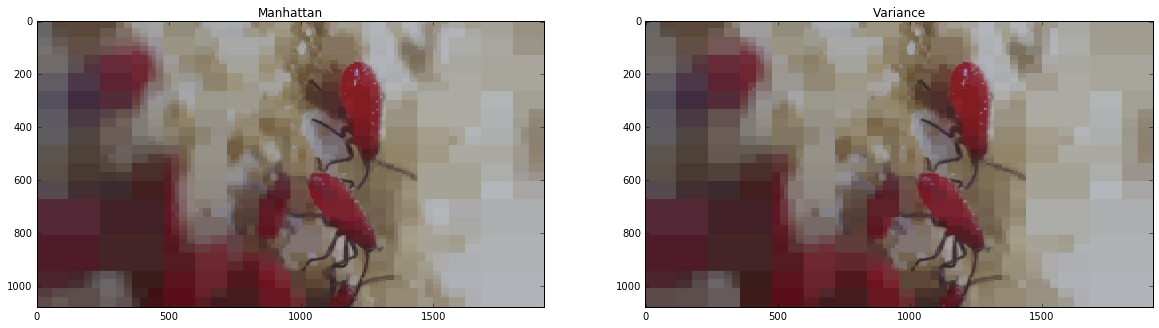

The manahattan splitting criterion took 0.273999929428 seconds to build.
It reduced to image from 2073600 pixels down to 946nodes
Reducing the size by a factor of 2191

The variance splitting criterion took 0.839999914169 seconds to build.
It reduced to image from 2073600 pixels down to 2443 nodes
Reducing the size by a factor of 848


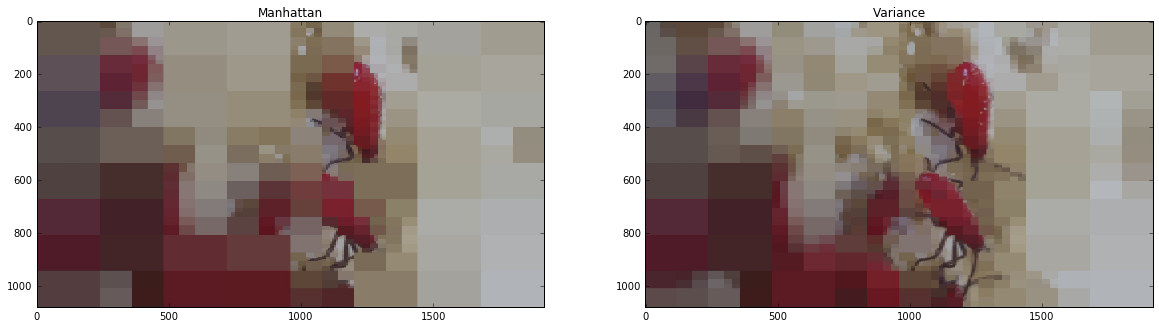

The manahattan splitting criterion took 0.226000070572 seconds to build.
It reduced to image from 2073600 pixels down to 313nodes
Reducing the size by a factor of 6624

The variance splitting criterion took 0.924000024796 seconds to build.
It reduced to image from 2073600 pixels down to 1906 nodes
Reducing the size by a factor of 1087


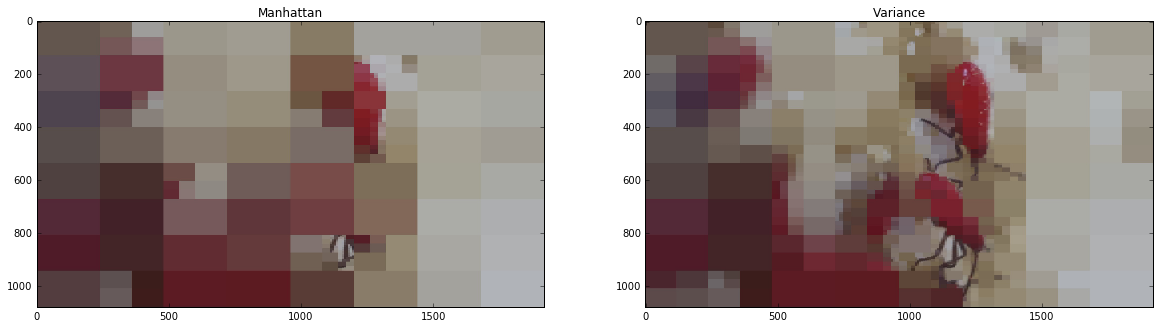

The manahattan splitting criterion took 0.110000133514 seconds to build.
It reduced to image from 2073600 pixels down to 82nodes
Reducing the size by a factor of 25287

The variance splitting criterion took 0.47000002861 seconds to build.
It reduced to image from 2073600 pixels down to 1435 nodes
Reducing the size by a factor of 1445


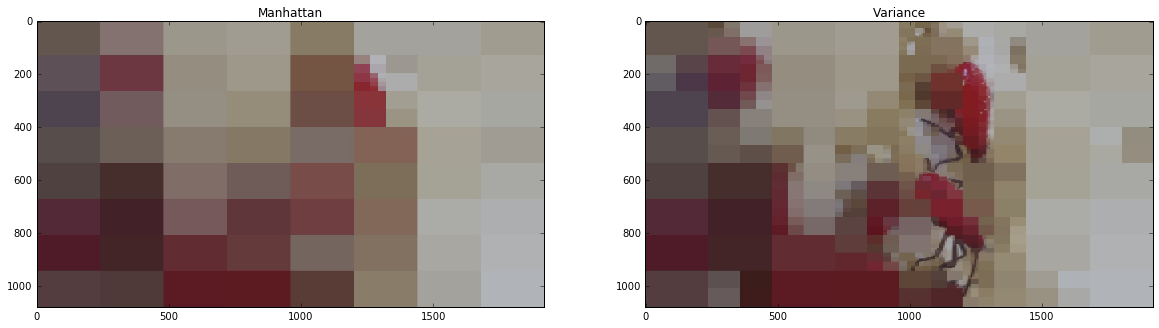

In [77]:
print_image('all')

From the above example we can see that the Mahattan distance is faster and tends to compress the image more. However it has considerably more loss than the variance which maintains its focus on the interesting regions fairly well even when the threshold is relaxed considerably.

Next we will see how the tree performs on some of the other images.

# Comparing outputs on different images

We fed several video clips into the algorithm to see how well it performed on the diverse images. We discuss the relative strengths and potential pitfalls of the compression on these different images. Our build method is by no means optimal and we discuss areas for improvement in the future work section below.

The manahattan splitting criterion took 1.30399990082 seconds to build.
It reduced to image from 2073600 pixels down to 7531 nodes
Reducing the size by a factor of 275

The variance splitting criterion took 2.67599987984 seconds to build.
It reduced to image from 2073600 pixels down to 7900 nodes
Reducing the size by a factor of 262


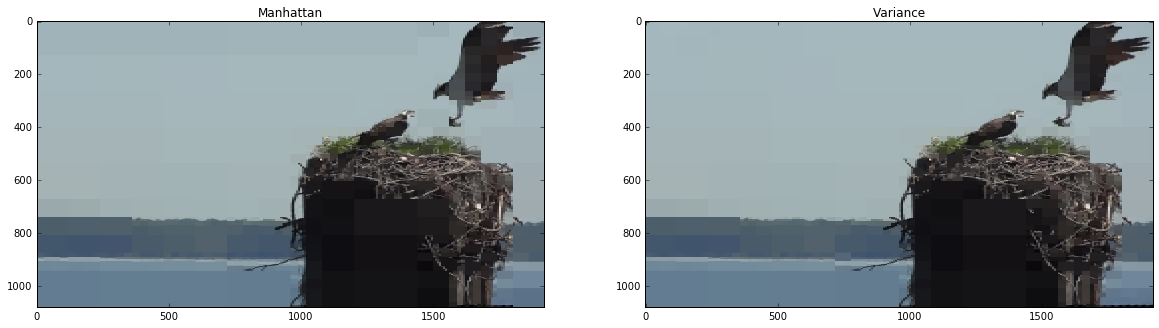

The manahattan splitting criterion took 6.31500005722 seconds to build.
It reduced to image from 8294400 pixels down to 31453 nodes
Reducing the size by a factor of 263

The variance splitting criterion took 12.9110000134 seconds to build.
It reduced to image from 8294400 pixels down to 29119 nodes
Reducing the size by a factor of 284


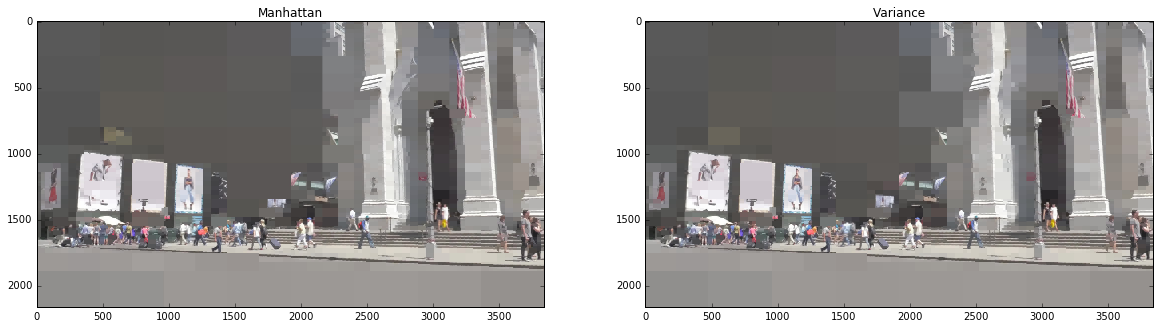

The manahattan splitting criterion took 0.445999860764 seconds to build.
It reduced to image from 2073600 pixels down to 2137 nodes
Reducing the size by a factor of 970

The variance splitting criterion took 0.824999809265 seconds to build.
It reduced to image from 2073600 pixels down to 1705 nodes
Reducing the size by a factor of 1216


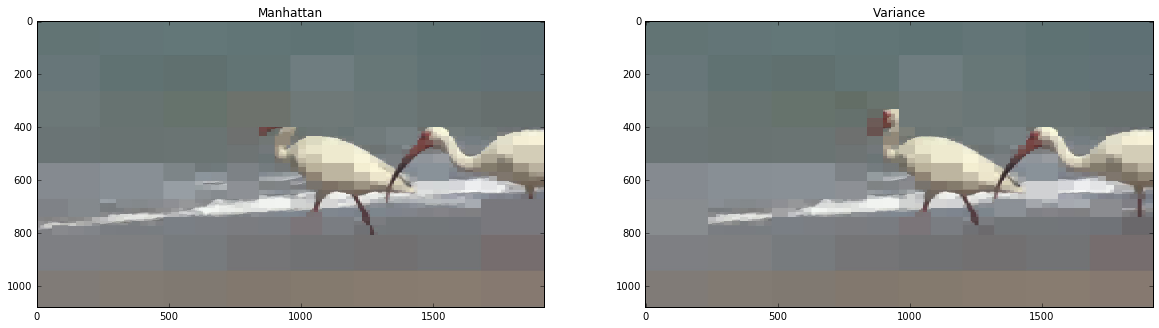

The manahattan splitting criterion took 0.280999898911 seconds to build.
It reduced to image from 2073600 pixels down to 1081 nodes
Reducing the size by a factor of 1918

The variance splitting criterion took 0.540999889374 seconds to build.
It reduced to image from 2073600 pixels down to 979 nodes
Reducing the size by a factor of 2118


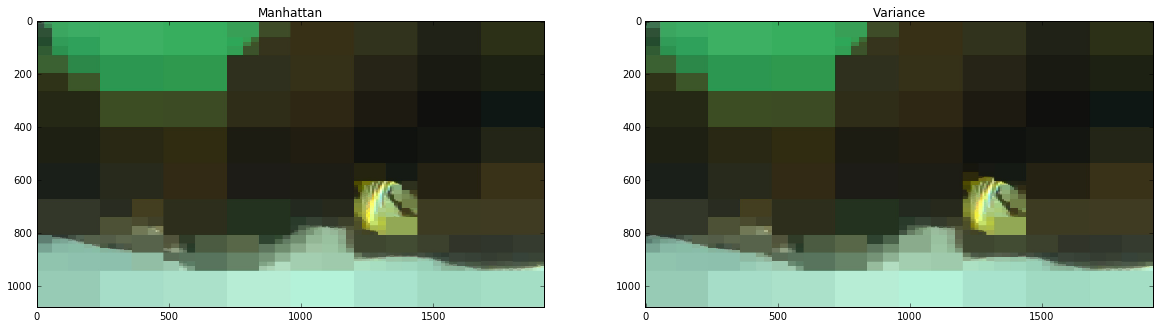

The manahattan splitting criterion took 0.625999927521 seconds to build.
It reduced to image from 2073600 pixels down to 2983 nodes
Reducing the size by a factor of 695

The variance splitting criterion took 1.15299987793 seconds to build.
It reduced to image from 2073600 pixels down to 2473 nodes
Reducing the size by a factor of 838


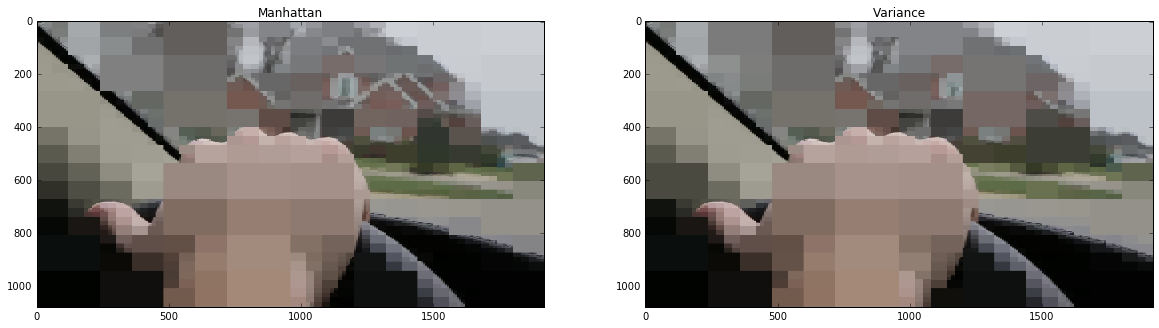

## Analysis of the Compression

From the above tests we can see a few things about how well it performs. A note on speed, these run about half as fast in the notebook as they do from the terminal.

**Osprey**

The important details are extracted. We might want to consider another threshold value since we're losing some background details. 

**Cathedral**

The time on this one is deceiving since it's a 4K image. It preserves the details suprisingly well considering the complexity of the scene. We will show more features about this particular compression in the next section.

**Ocean Birds**

We lose a lot of detail on this one. It shows that the simpler scenes require less restrictive thresholds. 

**Fish**

This extracts the fish incredibly well. We can also see how much of a difference the splitting criterion makes. 


**Driving**

Again we see how the different splitting criteria perform, and again we see that our threshold is too relaxed for the image. Even though the variance is using too broad a threshold, we use this to show some of the inherent robustness of the method in a later section.



## Matrix Representation

There are several useful operations that we can do at the Matrix level that aren't readily available in the tree form of the data structure. By having it in addition to the tree, we can apply many different algorithms and approaches depending on the constraints.

**Morphological Transformation to find dense objects**

Morphological transformations allow us to take the nodal representation of the image back to meaningful regions of the image. These roughly approximate the boundaries of the objects. However, given that there is no gaurentee that the boundaries fully knit together we can't use these masks to find all the edges in the frame. They will serve a purpose later when we want to find feathered boundary masks of objects. A nice note is that the computation time for these transformations is neglible on the compressed node structure.

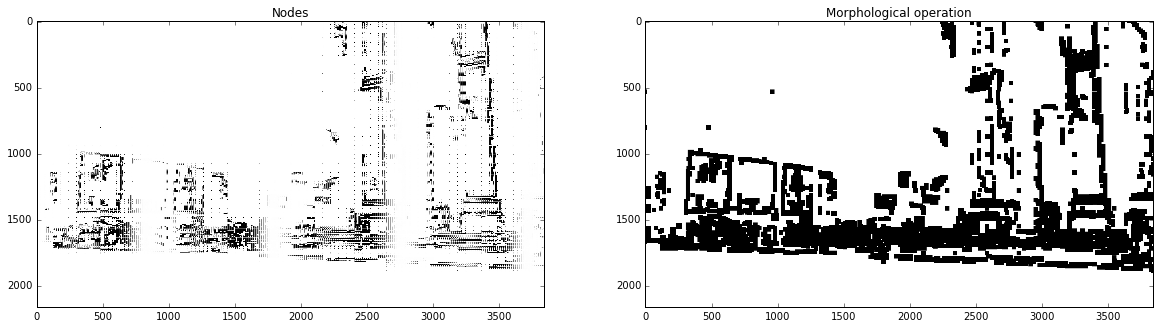

In [80]:
m_path,m_path2 = "morphtreevar1.jpg","openingtreevar1.jpg"
imcompare(m_path,m_path2,"Nodes","Morphological operation")

### Fractal Decompositions and Irregular Partitions

Notice that in the purely nodal representation above on the left we have periodic white bands going across that aren't present in the morphed image on the right. These periodic white bands line up with $T = k/4$ and fainter bands are noticable around $T = k/8$. This is a common problem with regular fractal partitions of the image. Objects that are partially split across two different nodes are sometimes lost. Regular regions have consistent edges which leads to these periodic bands of loss. This provides the motivation to use different partitions and stochastic fractals to decompose the image as their edges rarely align with objects. However even with these gaps when we use the open transform the edges knit back together. Leaf nodes are defined by their corners and center. Irregular Partitions allow for more coverage in the matrix representation.

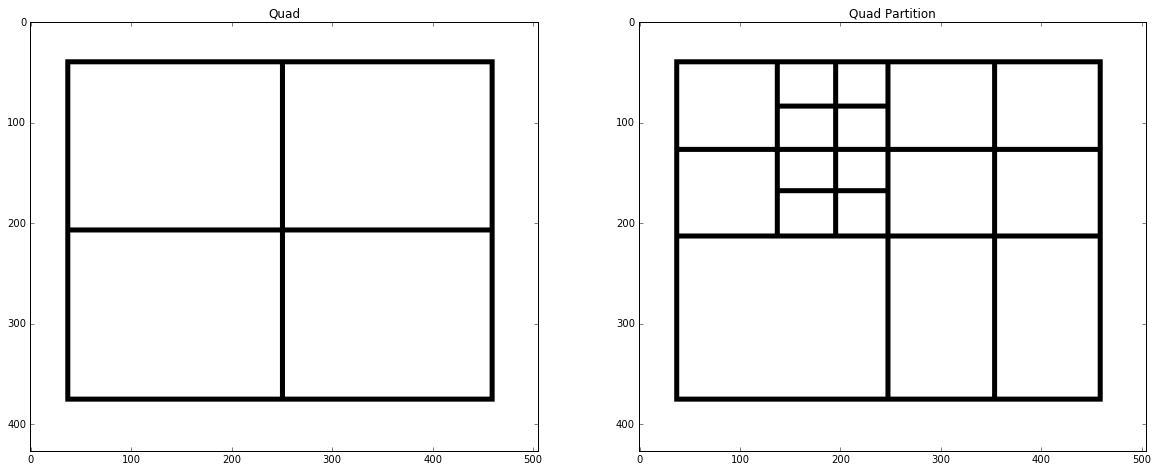

In [12]:
m_path,m_path2 = "Quad_partition.png","Quad.png"
imcompare(m_path,m_path2,"Quad","Quad Partition")

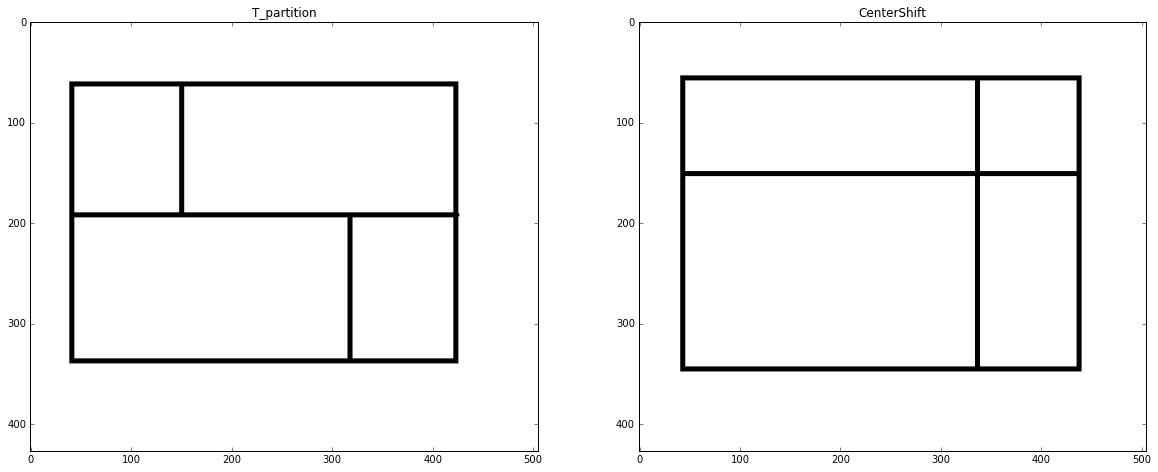

In [9]:
m_path,m_path2 = "irregular_partition.png","shifted.png"
imcompare(m_path,m_path2,"T_partition","CenterShift")

Here are two other self similar partitions that we can use to decompose the image. As can be seen below their edges are less predictable than the standard quadtree partition

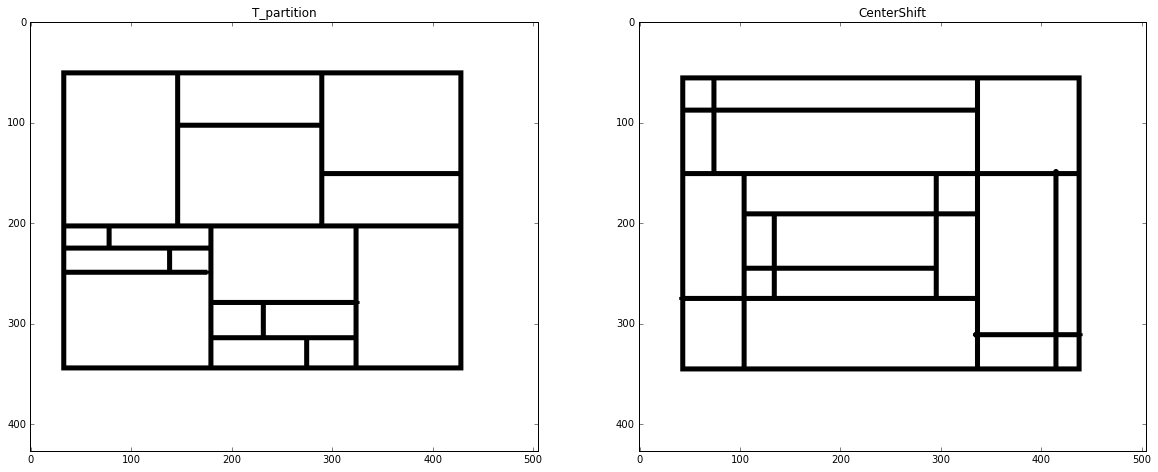

In [10]:
m_path,m_path2 = "irregular_partitioned.png","shifted_partition.png"
imcompare(m_path,m_path2,"T_partition","CenterShift")

As we can see the edges are much less regular which should allow for more robust edge detection.

# Triangulation to extract edges

The major weakness of using morphological transformations is the lack of closed boundaries. This weakness is covered by triangulation, we will be using the Delaunay triangulation for its relative speed and how it partitions the space. We use the node representation of our tree as the points to triangulate.

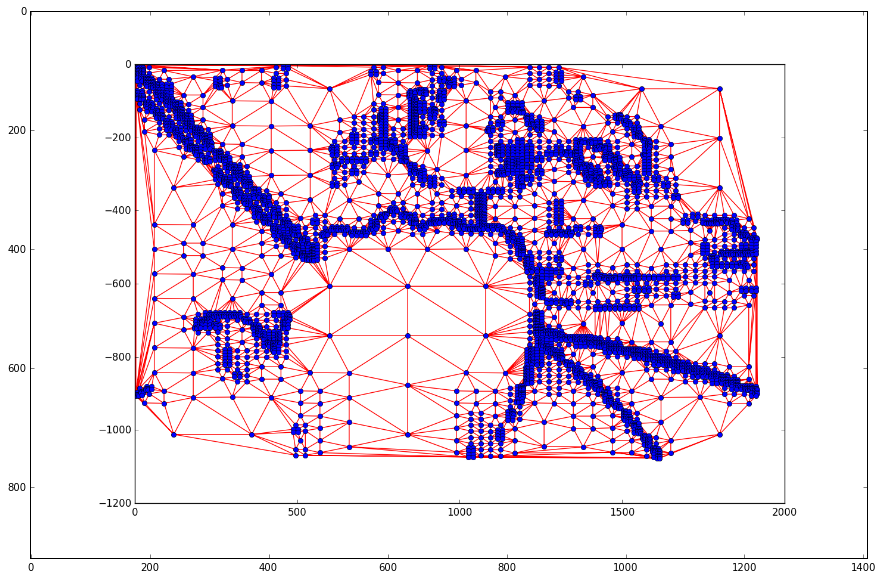

In [101]:
image = cv.imread("full_tri.png")

plt.figure(figsize = (15,12))
plt.imshow(image)
plt.show()

The mesh above looks promising, but the edges aren't entirely apparent. We will refine the mesh to further elucidate the meaninful edges in the image. Ideally each region will be surrounded by a simple closed loop, discretized by nodes. We can see on the back of the hand that it appears we're missing a node at the hand's edge. However when we refine the mesh and remove the large nodes this kind of gap is filled in by the triangulation.

### Mesh Refinement


Our first areas to refine are the large nodes. We distinguish between edge nodes and core nodes by the area of their regions. For this image we made the cut off at 16 pixels, this is another place where the method can be tuned. This is partially dependent on your choice of partition. An added benefit of splitting regions this way allows us to define them as both edge contour and a collection of interior points with which we can approximate a center of mass. This simplified form will be invaluable in speeding up comparisons between frames.

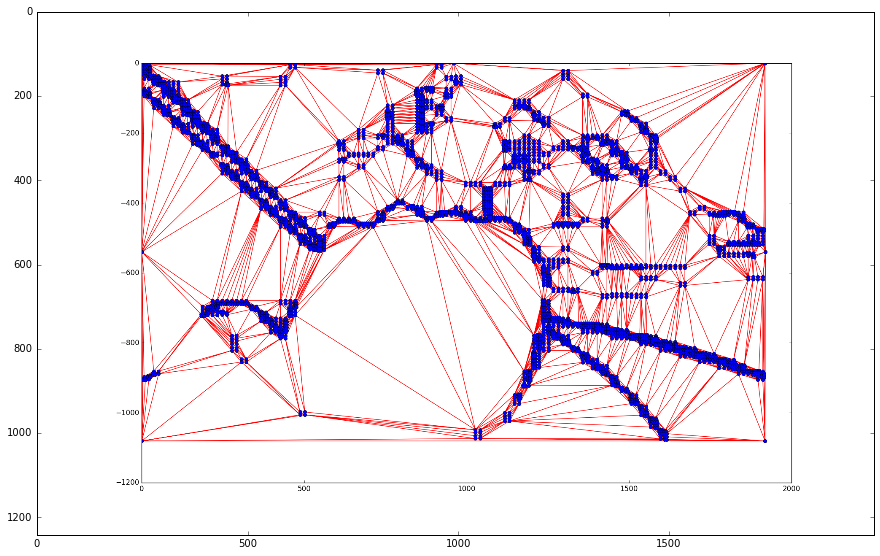

In [99]:
image = cv.imread("edge_tri.png")

plt.figure(figsize = (15,12))
plt.imshow(image)
plt.show()

We can wee that the interior nodes that were warping the boundary have been removed and a clear outline of the hand is readily apparent, but with some unecessary lines. The mesh can be further refined by removing the longest lines from each triangle. This subgraph is a spanning tree and called and the Urquhart graph. By observation, this further refinement removes a large majority of the unecessary lines and should leave us with the object boundaries. This refinement could be a good candidate for a neural network. This will be explored further as this project comes to fruition. 

Another possible way to build a spanning tree is to use Prims algorithm or another minimal spanning tree algorithm, like Kruskal or Dijkstra. One of the requirements is that the graph must be connexted. Sadly there is not a good library for going from a triangulation to a graph to a weighted adjency matrix what we could easily plug into. So we will have to build the method by hand.

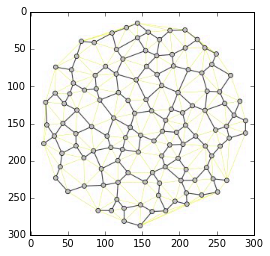

In [90]:
urqu = cv.imread('Urquhart.jpg')
plt.imshow(urqu)
plt.show()

# Conclusions

Using spatial trees to perform useful image processing functions like edge detection and movement prediction. What might not be readily apparent is just how many useful properties we get for free by using trees to do these functions. For example when we use the refined mesh from a tree we also gain useful information about the objects segmented. The objects are represented in two parts: the boundary of the object is a simple closed loop defined by the nodes that make up the curve, it is also defined by the set of points inside that curve. We call these two descriptions the edge and the core of the object respectively. When iterating through video we can compare the cores of sequential frames to determine which objects are not only still in the frame but how they moved. 

Even though we have made significant headway on this library there is still much to do and we look forward to improving this concept.

# Future Work

While, lots of headway has been made, this project is still in active development. There are numerous ways to improve the project.

**Object Tracking Through Video**

The main goal of this project is to create a method fast enough to stream HD video with live processing. Once we finish the segmentation algorithm we have a succinct way of comparing objects as they move through the frame leading to a computationally efficient robust method of object tracking.

**Further Mesh Refinement**

An alternative to using an Urquhart graph to find edges, it may be possible to use a neural network to efficiently and accurately identify possible edge configurations.
  

**Adaptive Build Criteria**

With diverse options to build the tree and combining network comparisons with the tree representation of the tree we can identify which regions to focus on in the future. 

**Code Optimization**

We could change from python to a lower level language to improve the speed of our algorithm. There are several functions that were implemented as a proof of concept that can be optimized to further decrease the build time of the tree. 